In [1]:
from mylib.statistic_test import *

code_id = '0357 - Examination of Re-Match Results'
loc = join(figpath, code_id)
mkdir(loc)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0357 - Examination of Re-Match Results is already existed!


# Two types of modifications: Fill In, Replacement

In [ ]:
def _get_most_similar_pair(
    index_map_line: np.ndarray,
    index_map2: np.ndarray
) -> int:
    index_map2_proc = cp.deepcopy(index_map2)
    index_map2_proc -= index_map_line[:, np.newaxis]
    
    count_mat = np.where(index_map2_proc == 0, 1, 0)
    return np.argmax(np.sum(count_mat, axis=0))

def analyze_rematch(
    i: int,
    ff: pd.DataFrame = f_CellReg_modi,
    s_thre: int = 10
):
    mouse = int(ff['MiceID'][i])
    paradigm = ff['paradigm'][i]
    assert paradigm == 'CrossMaze', f"Only support CrossMaze, got {paradigm}"
    
    with open(ff['cellreg_folder'][i], 'rb') as f:
        index_map = pickle.load(f).astype(np.int64)
        
    index_map2 = ReadCellReg(ff['cellreg_ori_folder'][i]).astype(np.int64)
    
    if index_map2.shape[0] > 20:
        s_thre = 10
    else:
        s_thre = 7
    
    modification_log_fill = np.zeros(6)
    # Column 0: fill-in occured session
    # Column 1: fill-in cell
    # Column 2: latest predecessor session
    # Column 3: latest predecessor cell
    # Column 4: earliest successor session
    # Column 5: earliest successor cell
    
    modification_log_repl = np.zeros(7)
    # Column 0: replacement occured session
    # Column 1: replacement cell
    # Column 2: Original Cell
    # Column 3: latest predecessor session
    # Column 4: latest predecessor cell
    # Column 5: earliest successor session
    # Column 6: earliest successor cell

    # process fill-in case:
    is_cell = np.where(index_map2 != 0, 1, 0)
    cell_counts = np.sum(is_cell, axis=0)
    print("  Fill-in Analysis")
    for n in tqdm(np.where(cell_counts >= s_thre)[0]):
        
        pl = _get_most_similar_pair(
            index_map2[:, n], index_map
        ) # Paired line
        
        resi = index_map[:, pl] - index_map2[:, n]
        fillin_idx = np.where((resi > 0) & (index_map2[:, n] == 0))[0]
        if len(fillin_idx) == 0:
            continue
        
        for idx in fillin_idx:
            log_fill = np.zeros(6)-1
            log_fill[0] = idx
            log_fill[1] = index_map[idx, pl]
            latest_prec = np.where(resi[:idx] == 0)[0]
            if len(latest_prec) > 0:
                latest_prec = latest_prec[-1]
                log_fill[2] = latest_prec
                log_fill[3] = index_map[latest_prec, pl]
            earliest_succ = np.where(resi[idx:] == 0)[0]
            if len(earliest_succ) > 0:
                earliest_succ = earliest_succ[0] + idx
                log_fill[4] = earliest_succ
                log_fill[5] = index_map[earliest_succ, pl]
            modification_log_fill = np.vstack((modification_log_fill, log_fill))
    
    modification_log_fill = modification_log_fill[1:, :]
    
    # process replacement case:
    print("  Replacement Analysis")
    for n in tqdm(np.where(cell_counts >= s_thre)[0]):
        pl = _get_most_similar_pair(
            index_map2[:, n], index_map
        ) # Paired line
        
        resi = index_map[:, pl] - index_map2[:, n]
        repl_idx = np.where((resi != 0) & (index_map2[:, n] != 0))[0]
        if len(repl_idx) == 0:
            continue
        
        for idx in repl_idx:
            log_repl = np.zeros(7)-1
            log_repl[0] = idx
            log_repl[1] = index_map[idx, pl]
            log_repl[2] = index_map2[idx, n]
            latest_prec = np.where(resi[:idx] == 0)[0]
            if len(latest_prec) > 0:
                latest_prec = latest_prec[-1]
                log_repl[3] = latest_prec
                log_repl[4] = index_map[latest_prec, pl]
            earliest_succ = np.where(resi[idx:] == 0)[0]
            if len(earliest_succ) > 0:
                earliest_succ = earliest_succ[0] + idx
                log_repl[5] = earliest_succ
                log_repl[6] = index_map[earliest_succ, pl]
            modification_log_repl = np.vstack((modification_log_repl, log_repl))
            
    modification_log_repl = modification_log_repl[1:, :]
    
    with open(ff['Trace File'][i], 'rb') as f:
        trace_mdays = pickle.load(f)
        
    trace_mdays['fill_in_log'] = modification_log_fill
    trace_mdays['replace_log'] = modification_log_repl
    trace_mdays['total_modified_neurons'] = np.where(cell_counts >= s_thre)[0].shape[0]
    
    with open(ff['Trace File'][i], 'wb') as f:
        pickle.dump(trace_mdays, f)
    print("  Saved.")
        
for i in range(14):
    continue
    print(f"{i}, {f_CellReg_modi['Trace File'][i]} ----------")
    analyze_rematch(i)


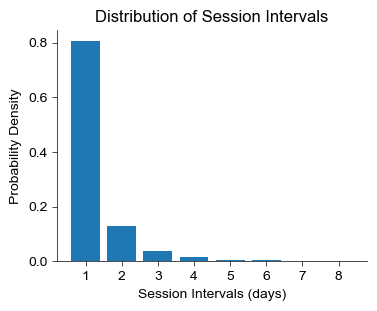

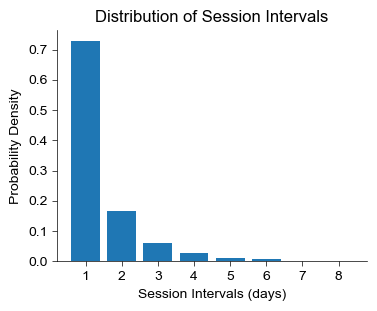

Fill-in: 0.07003448836577424, min 0.03414340228961639, max 0.10500894454382827
Replace: 0.06614368599031482, min 0.003205128205128205, max 0.24855252274607112
Raw Fill-in: 1.2316572794180114, min 0.44386422976501305, max 2.730232558139535
Raw Replace: 1.2293851246347347, min 0.041666666666666664, max 3.7397476340694005


In [ ]:
def distribution_of_session_intervals():
    session_intervals_fill = []
    session_intervals_repl = []
    ratio_fill = []
    ratio_repl = []
    
    raw_fill = []
    raw_repl = []
    for i in range(14):
        with open(f_CellReg_modi['Trace File'][i], 'rb') as f:
            trace_mdays = pickle.load(f)
        fill_in_log = trace_mdays['fill_in_log']
        replace_log = trace_mdays['replace_log']
        ratio_fill.append(fill_in_log.shape[0] / trace_mdays['total_modified_neurons']/ trace_mdays['index_map'].shape[0])
        ratio_repl.append(replace_log.shape[0] / trace_mdays['total_modified_neurons']/ trace_mdays['index_map'].shape[0])
        raw_fill.append(fill_in_log.shape[0] / trace_mdays['total_modified_neurons'])
        raw_repl.append(replace_log.shape[0] / trace_mdays['total_modified_neurons'])

        for i in range(fill_in_log.shape[0]):
            s1 = fill_in_log[i, 0]
            s2 = fill_in_log[i, 2]
            s3 = fill_in_log[i, 4]
            
            if s2 != -1 and s3 != -1:
                session_intervals_fill.append(min(s3-s1, s1-s2))
            elif s2 != -1 and s3 == -1:
                session_intervals_fill.append(s1-s2)
            elif s2 == -1 and s3 != -1:
                session_intervals_fill.append(s3-s1)
                
        for i in range(replace_log.shape[0]):
            s1 = replace_log[i, 0]
            s2 = replace_log[i, 3]
            s3 = replace_log[i, 5]
            
            if s2 != -1 and s3 != -1:
                session_intervals_repl.append(min(s3-s1, s1-s2))
            elif s2 != -1 and s3 == -1:
                session_intervals_repl.append(s1-s2)
            elif s2 == -1 and s3 != -1:
                session_intervals_repl.append(s3-s1)
        
    
    session_intervals_fill = np.array(session_intervals_fill)
    plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.hist(session_intervals_fill, bins=np.linspace(0.5, 8.5, 9), density=True, rwidth=0.8)
    plt.xticks(np.linspace(1, 8, 8))
    plt.xlabel("Session Intervals (days)")
    plt.ylabel("Probability Density")
    plt.title("Distribution of Session Intervals")
    #plt.tight_layout()
    #plt.savefig(join(loc, "Session Intervals Distribution.png"), dpi=300)
    plt.show()
            
    session_intervals_repl = np.array(session_intervals_repl)
    plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.hist(session_intervals_repl, bins=np.linspace(0.5, 8.5, 9), density=True, rwidth=0.8)
    plt.xticks(np.linspace(1, 8, 8))
    plt.xlabel("Session Intervals (days)")
    plt.ylabel("Probability Density")
    plt.title("Distribution of Session Intervals")
    #plt.tight_layout()
    #plt.savefig(join(loc, "Session Intervals Distribution - Replacement.png"), dpi=300)
    plt.show()
    
    ratio_fill = np.array(ratio_fill)
    ratio_repl = np.array(ratio_repl)
    print(f"Fill-in: {np.mean(ratio_fill)}, min {np.min(ratio_fill)}, max {np.max(ratio_fill)}")
    print(f"Replace: {np.mean(ratio_repl)}, min {np.min(ratio_repl)}, max {np.max(ratio_repl)}")
    print(f"Raw Fill-in: {np.mean(raw_fill)}, min {np.min(raw_fill)}, max {np.max(raw_fill)}")
    print(f"Raw Replace: {np.mean(raw_repl)}, min {np.min(raw_repl)}, max {np.max(raw_repl)}")



distribution_of_session_intervals()

# Identify Continously tracked pieces

0, D:\Data\Long-term\Cross_maze\10209\Maze1-footprint\trace_mdays_conc.pkl ----------
1, D:\Data\Long-term\Cross_maze\10209\Maze1-2-footprint\trace_mdays_conc.pkl ----------
2, D:\Data\Long-term\Cross_maze\10209\Maze2-footprint\trace_mdays_conc.pkl ----------
3, D:\Data\Long-term\Cross_maze\10212\Maze1-footprint\trace_mdays_conc.pkl ----------
4, D:\Data\Long-term\Cross_maze\10212\Maze1-2-footprint\trace_mdays_conc.pkl ----------
5, D:\Data\Long-term\Cross_maze\10212\Maze2-footprint\trace_mdays_conc.pkl ----------
6, D:\Data\Long-term\Cross_maze\10224\Maze1-footprint\trace_mdays_conc.pkl ----------
7, D:\Data\Long-term\Cross_maze\10224\Maze2-footprint\trace_mdays_conc.pkl ----------
8, D:\Data\Long-term\Cross_maze\10227\Maze1-footprint\trace_mdays_conc.pkl ----------
9, D:\Data\Long-term\Cross_maze\10227\Maze2-footprint\trace_mdays_conc.pkl ----------
10, D:\Data\Long-term\Cross_maze\10232\Maze1-footprint\trace_mdays_conc.pkl ----------
11, D:\Data\Long-term\Cross_maze\10232\Maze2-foot

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_19236\577227576.py:73: RuntimeWarning: invalid value encountered in cast
  index_map = pickle.load(f).astype(np.int64)


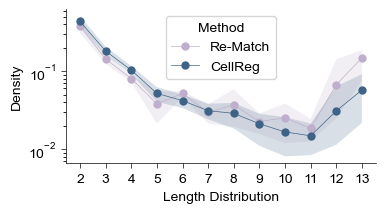

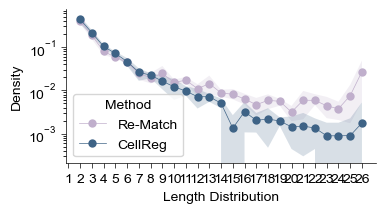

MA, 09 & 12:
  Length 13: TtestResult(statistic=2.2508875612121773, pvalue=0.10984780720950593, df=3)
  Length 14: TtestResult(statistic=5.425555141502817, pvalue=0.01228628368507157, df=3)
  Length 15: TtestResult(statistic=3.6017798108414585, pvalue=0.03671601723286078, df=3)
  Length 16: TtestResult(statistic=9.089432108398354, pvalue=0.00281353943454663, df=3)
  Length 17: TtestResult(statistic=1.453028502355671, pvalue=0.24216625259505611, df=3)
  Length 18: TtestResult(statistic=2.42673619390265, pvalue=0.09360281916356118, df=3)
  Length 19: TtestResult(statistic=4.957869076407413, pvalue=0.015753384377640792, df=3)
  Length 20: TtestResult(statistic=1.493858520962158, pvalue=0.232063215733239, df=3)
  Length 21: TtestResult(statistic=1.8893673164453522, pvalue=0.15525144921571196, df=3)
  Length 22: TtestResult(statistic=4.136960253015638, pvalue=0.02563673341812744, df=3)
  Length 23: TtestResult(statistic=2.990173896425623, pvalue=0.0581225633639807, df=3)
  Length 24: TtestR

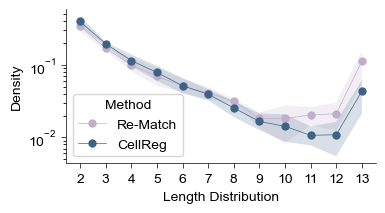

  Mean: 0.18119812168084087, STD: 0.06579078932108669, Max: 0.2874493927125506, Min: 0.04946236559139785, Median: 0.1857198064867031, df: 13
  Mean: 0.08126152691407498, STD: 0.038657399259114385, Max: 0.16159695817490494, Min: 0.018789144050104383, Median: 0.08016831009860592, df: 13
TtestResult(statistic=7.662784396194723, pvalue=3.571690059613471e-06, df=13)


In [ ]:
def get_n_continuosly_tracked(
    index_map: np.ndarray
):
    index_map = index_map.astype(np.int64)
    is_cell = np.where(index_map != 0, 1, 0)
    S = index_map.shape[0]
    
    count = []
    
    for i in range(S-1):
        for j in range(i+1, S):
            if i == 0:
                if j == S-1:
                    idx = np.where(
                        np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)
                    )[0]
                else:
                    idx = np.where(
                        (np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)) &
                        (is_cell[j+1, :] == 0)
                    )[0]
                    
            elif i == 1:
                if j == S-1:
                    idx = np.where(
                        (np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)) &
                        (is_cell[i-1, :] == 0)
                    )[0]
                else:
                    idx = np.where(
                        (np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)) &
                        (is_cell[i-1, :] == 0) &
                        (is_cell[j+1, :] == 0)
                    )[0]
                    
            else:
                if j == S-1:
                    idx = np.where(
                        (np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)) &
                        (is_cell[i-1, :] == 0) &
                        (is_cell[i-2, :] == 0)
                    )[0]
                else:
                    idx = np.where(
                        (np.sum(is_cell[i:j+1, :], axis=0) == (j - i + 1)) &
                        (is_cell[i-1, :] == 0) &
                        (is_cell[i-2, :] == 0) &
                        (is_cell[j+1, :] == 0)
                    )[0]
    
            count.append(np.repeat(j-i+1, idx.shape[0]))
    return np.concatenate(count)

if exists(join(figdata, f" {code_id} [Length Distribution].pkl")) == False:
    LenDistri = {
        "MiceID": [],
        "Spatial Map": [],
        "Length Distribution": [],
        "Density": [],
        "Method": [] # Re-Maching or CellReg
    }
    
    summed_density_rem = []
    summed_density_cr = []
    
    for i in range(14):
        print(f"{i}, {f_CellReg_modi['Trace File'][i]} ----------")
        paradm = f_CellReg_modi['paradigm'][i]
        maze_type = int(f_CellReg_modi['maze_type'][i])
        
        if paradm == 'CrossMaze':
            with open(f_CellReg_modi['cellreg_folder'][i], 'rb') as f:
                index_map = pickle.load(f).astype(np.int64)
        else:
            index_map = ReadCellReg(f_CellReg_modi['cellreg_folder'][i]).astype(np.int64)
        
        S = index_map.shape[0]
            
        len_distri = get_n_continuosly_tracked(index_map)
        density, bins = np.histogram(len_distri, bins=np.linspace(1.5, S+0.5, S), density=True)
        bins = (bins[1:] + bins[:-1]) / 2

        LenDistri['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), bins.shape[0]))
        if paradm == 'CrossMaze':
            LenDistri['Spatial Map'].append(np.repeat('MA' if maze_type == 1 else 'MB', bins.shape[0]))
        elif paradm == 'ReverseMaze':
            LenDistri['Spatial Map'].append(np.repeat('MAf & MAb', bins.shape[0]))
        else:
            LenDistri['Spatial Map'].append(np.repeat('HPf & HPb', bins.shape[0]))
        LenDistri['Length Distribution'].append(bins)
        LenDistri['Density'].append(density)
        
        summed_density_rem.append(np.sum(density[8:])) # Length >= 10
        if paradm == 'CrossMaze':
            LenDistri['Method'].append(np.repeat('Re-Match', bins.shape[0]))
        else:
            LenDistri['Method'].append(np.repeat('CellReg', bins.shape[0]))
            continue
        
        index_map2 = ReadCellReg(f_CellReg_modi['cellreg_ori_folder'][i]).astype(np.int64)
        
        S = index_map2.shape[0]
        len_distri2 = get_n_continuosly_tracked(index_map2)
        density2, bins2 = np.histogram(len_distri2, bins=np.linspace(1.5, S+0.5, S), density=True)
        bins2 = (bins2[1:] + bins2[:-1]) / 2
        summed_density_cr.append(np.sum(density2[8:])) # Length >= 10

        LenDistri['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), bins2.shape[0]))
        LenDistri['Spatial Map'].append(np.repeat('MA' if maze_type == 1 else 'MB', bins2.shape[0]))
        LenDistri['Length Distribution'].append(bins2)
        LenDistri['Density'].append(density2)
        LenDistri['Method'].append(np.repeat('CellReg', bins2.shape[0]))
    
    for k in LenDistri.keys():
        LenDistri[k] = np.concatenate(LenDistri[k])
        
    with open(join(figdata, f"{code_id} [Length Distribution].pkl"), 'wb') as f:
        pickle.dump(LenDistri, f)
    
    LenDistriDF = pd.DataFrame(LenDistri)
    LenDistriDF.to_excel(join(figdata, f"{code_id} [Length Distribution].xlsx"), index=False)
    print(len(LenDistriDF))
else:
    with open(join(figdata, f"{code_id} [Length Distribution].pkl"), 'rb') as f:
        LenDistri = pickle.load(f)


def plot_subdata(SubData, file_name: str, palette: list = ['#c0afcc', '#3e6386'], hue='Method'):
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Length Distribution', 
        y='Density',
        hue=hue, 
        palette=palette,
        data=SubData,
        ax=ax,
        linewidth=0.5,
        err_kws={'edgecolor': None},
        marker='o',
        markersize=6,
        markeredgewidth=0
    )
    ax.semilogy()
    xlim = ax.get_xlim()
    ax.set_xticks(np.linspace(1, 26, 26))
    ax.set_xlim(xlim)
    plt.savefig(join(loc, f"{file_name}.png"), dpi=600)
    plt.savefig(join(loc, f"{file_name}.svg"), dpi=600)
    plt.show()

SubData = SubDict(
    LenDistri, LenDistri.keys(), 
    np.where(
        (LenDistri['Spatial Map'] == 'MA') &
        (np.isin(LenDistri['MiceID'], [10209, 10212]))
    )[0]
)
plot_subdata(SubData, join(loc, "Length Distribution - MA (10209, 10212)"))

SubData = SubDict(
    LenDistri, LenDistri.keys(), 
    np.where(
        (LenDistri['Spatial Map'] == 'MA') &
        (np.isin(LenDistri['MiceID'], [10209, 10212]) == False)
    )[0]
)
plot_subdata(SubData, join(loc, "Length Distribution - MA Other"))
print('MA, 09 & 12:')
for l in range(13, 27):
    idx_rem = np.where(
        (SubData['Length Distribution'] == l) &
        (SubData['Method'] == 'Re-Match')
    )[0]
    idx_cr = np.where(
        (SubData['Length Distribution'] == l) &
        (SubData['Method'] == 'CellReg')
    )[0]
    print(f"  Length {l}: {ttest_rel(SubData['Density'][idx_rem], SubData['Density'][idx_cr])}")
print()

SubData = SubDict(
    LenDistri, LenDistri.keys(), 
    np.where(
        (LenDistri['Spatial Map'] == 'MB')
    )[0]
)
plot_subdata(SubData, join(loc, "Length Distribution - MB"))

"""
SubData = SubDict(
    LenDistri, LenDistri.keys(), 
    np.where(
        (np.isin(LenDistri['Spatial Map'], ['MAf & MAb', 'HPf & HPb']))
    )[0]
)
plot_subdata(SubData, join(loc, "Length Distribution - Reverse & HP"), palette=['#0c3256', '#6fb6b6'], hue='Spatial Map')
"""
summed_density_cr = np.array(summed_density_cr)
summed_density_rem = np.array(summed_density_rem)
print_estimator(summed_density_rem)
print_estimator(summed_density_cr)
print(ttest_rel(summed_density_rem, summed_density_cr))

# Spatial Map Correlation.

Predecessor, Fill-in:
  Real vs. Ctrl: TtestResult(statistic=-10.396992705831563, pvalue=1.1431807465718941e-07, df=13)
  Real vs. Shuf: TtestResult(statistic=15.022018444352938, pvalue=1.3557659226517624e-09, df=13)
  Ctrl vs. Shuf: TtestResult(statistic=18.301413689607372, pvalue=1.1604197988244474e-10, df=13)



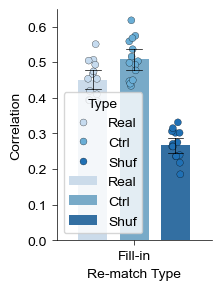

Predecessor, Replacement:
  Real vs. Ctrl: TtestResult(statistic=-2.311889950973484, pvalue=0.037814835825171755, df=13)
  Real vs. Shuf: TtestResult(statistic=5.368181763900436, pvalue=0.00012793433086606963, df=13)
  Ctrl vs. Shuf: TtestResult(statistic=3.8617950026971424, pvalue=0.0019631512662233843, df=13)



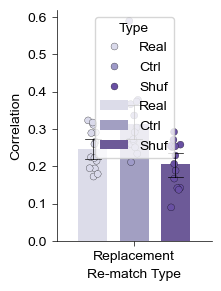

Successor, Fill-in:
  Real vs. Ctrl: TtestResult(statistic=-6.849263016894242, pvalue=1.1716201290067348e-05, df=13)
  Real vs. Shuf: TtestResult(statistic=14.059104977024388, pvalue=3.0615345773627948e-09, df=13)
  Ctrl vs. Shuf: TtestResult(statistic=18.43412543720763, pvalue=1.0598282971969321e-10, df=13)



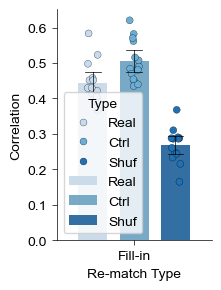

Successor, Replacement:
  Real vs. Ctrl: TtestResult(statistic=-1.5208514826958077, pvalue=0.15224160258255195, df=13)
  Real vs. Shuf: TtestResult(statistic=2.8363584859517332, pvalue=0.01401874790912959, df=13)
  Ctrl vs. Shuf: TtestResult(statistic=3.9964510152824553, pvalue=0.001522218638080477, df=13)



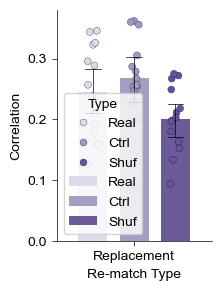

In [14]:
def calc_corr(
    index_map: np.ndarray,
    i: int, 
    j: int,
    traces: list[dict],
):
    idx = np.where((index_map[i, :] != 0) & (index_map[j, :] != 0))[0]
    if len(idx) == 0:
        return np.nan
    else:
        corr = np.zeros(len(idx))
        for k in range(len(idx)):
            c1 = traces[i]['smooth_map_all'][index_map[i, idx[k]] - 1, :]
            c2 = traces[j]['smooth_map_all'][index_map[j, idx[k]] - 1, :]
            corr[k] = np.corrcoef(c1, c2)[0, 1]
            
    return np.nanmean(corr)

def get_corr(
    i: int, 
    ff: pd.DataFrame = f_CellReg_modi
):
    mouse = int(ff['MiceID'][i])
    stage = ff['Stage'][i]
    session = int(ff['session'][i])

    with open(ff['Trace File'][i], 'rb') as handle:
        trace_mdays = pickle.load(handle)
    index_map = trace_mdays['index_map'].astype(np.int64)
    
    fdata = f1
    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]
    
    traces = []
    for fi in file_indices:
        with open(fdata['Trace File'][fi], 'rb') as handle:
            trace = pickle.load(handle)
        traces.append(trace)
        
    index_map2 = ReadCellReg(ff['cellreg_ori_folder'][i]).astype(np.int64)
    corr_mat = np.zeros((index_map.shape[0], index_map.shape[0]))*np.nan
    for m in range(index_map.shape[0]):
        for n in range(index_map.shape[0]):
            if m == n:
                continue
            
            corr_mat[m, n] = calc_corr(
                index_map2, m, n, traces
            )
        
    res = {
        "Compare target": [], # Predecessor or Successor
        "Type": [], # 'Real': filled-in/replaced neuron vs. its predecessor/successor; 'Random': filled-in/replaced neuron vs. random neuron
                    # 'Ctrl': Averaged CellReg neurons vs. its predecessor/successor
                    # "Shuf": Averaged CellReg neurons vs. random neuron
        "Re-match Type": [], # 'Fill-in' or 'Replacement'
        "Correlation": []
    }
    
    fill_in_log = trace_mdays['fill_in_log']
    replace_log = trace_mdays['replace_log']
    
    print("  Fill-in Analysis")
    for j in tqdm(range(fill_in_log.shape[0])):
        pre, curr, suc = int(fill_in_log[j, 2]), int(fill_in_log[j, 0]), int(fill_in_log[j, 4])
        pre_cell, curr_cell, suc_cell = int(fill_in_log[j, 3]), int(fill_in_log[j, 1]), int(fill_in_log[j, 5])
        neighbor_cell = int(traces[curr]['nearest_roi'][curr_cell - 1])

        if pre != -1:
            corr_with_pre = np.corrcoef(
                traces[curr]['smooth_map_all'][curr_cell - 1, :],
                traces[pre]['smooth_map_all'][pre_cell - 1, :]
            )[0, 1]
            corr_with_pre_ctrl = corr_mat[curr, pre]
            corr_with_pre_rand = np.corrcoef(
                traces[curr]['smooth_map_all'][neighbor_cell - 1, :],
                traces[pre]['smooth_map_all'][pre_cell - 1, :]
            )[0, 1]
            
            res['Compare target'].append(np.repeat('Predecessor', 3))
            res['Type'].append(np.array(['Real', 'Ctrl', 'Shuf']))
            res['Re-match Type'].append(np.repeat('Fill-in', 3))
            res['Correlation'].append(np.array([corr_with_pre, corr_with_pre_ctrl, corr_with_pre_rand]))
        
        if suc != -1:
            corr_with_suc = np.corrcoef(
                traces[curr]['smooth_map_all'][curr_cell - 1, :],
                traces[suc]['smooth_map_all'][suc_cell - 1, :]
            )[0, 1]
            corr_with_suc_ctrl = corr_mat[curr, suc]
            corr_with_suc_rand = np.corrcoef(
                traces[curr]['smooth_map_all'][neighbor_cell - 1, :],
                traces[suc]['smooth_map_all'][suc_cell - 1, :]
            )[0, 1]
            
            res['Compare target'].append(np.repeat('Successor', 3))
            res['Type'].append(np.array(['Real', 'Ctrl', 'Shuf']))
            res['Re-match Type'].append(np.repeat('Fill-in', 3))
            res['Correlation'].append(np.array([corr_with_suc, corr_with_suc_ctrl, corr_with_suc_rand]))
        
    print("  Replacement Analysis")
    for j in tqdm(range(replace_log.shape[0])):
        pre, curr, suc = int(replace_log[j, 3]), int(replace_log[j, 0]), int(replace_log[j, 5])
        pre_cell, curr_cell, suc_cell = int(replace_log[j, 4]), int(replace_log[j, 1]), int(replace_log[j, 6])
        neighbor_cell = int(traces[curr]['nearest_roi'][curr_cell - 1])
        suc_ori_cell = int(replace_log[j, 2])
        
        if pre != -1:
            corr_with_pre = np.corrcoef(
                traces[curr]['smooth_map_all'][curr_cell - 1, :],
                traces[pre]['smooth_map_all'][pre_cell - 1, :]
            )[0, 1]
            corr_with_pre_ctrl = np.corrcoef(
                traces[curr]['smooth_map_all'][suc_ori_cell - 1, :],
                traces[pre]['smooth_map_all'][pre_cell - 1, :]
            )[0, 1]
            corr_with_pre_rand = np.corrcoef(
                traces[curr]['smooth_map_all'][neighbor_cell - 1, :],
                traces[pre]['smooth_map_all'][pre_cell - 1, :]
            )[0, 1]
            
            res['Compare target'].append(np.repeat('Predecessor', 3))
            res['Type'].append(np.array(['Real', 'Ctrl', 'Shuf']))
            res['Re-match Type'].append(np.repeat('Replacement', 3))
            res['Correlation'].append(np.array([corr_with_pre, corr_with_pre_ctrl, corr_with_pre_rand]))
        
        if suc != -1:
            corr_with_suc = np.corrcoef(
                traces[curr]['smooth_map_all'][curr_cell - 1, :],
                traces[suc]['smooth_map_all'][suc_cell - 1, :]
            )[0, 1]
            corr_with_suc_ctrl = np.corrcoef(
                traces[curr]['smooth_map_all'][suc_ori_cell - 1, :],
                traces[suc]['smooth_map_all'][suc_cell - 1, :]
            )[0, 1]
            corr_with_suc_rand = np.corrcoef(
                traces[curr]['smooth_map_all'][neighbor_cell - 1, :],
                traces[suc]['smooth_map_all'][suc_cell - 1, :]
            )[0, 1]
            
            res['Compare target'].append(np.repeat('Successor', 3))
            res['Type'].append(np.array(['Real', 'Ctrl', 'Shuf']))
            res['Re-match Type'].append(np.repeat('Replacement', 3))
            res['Correlation'].append(np.array([corr_with_suc, corr_with_suc_ctrl, corr_with_suc_rand]))
    
    for k in res.keys():
        res[k] = np.concatenate(res[k])
    
    Avg = {
        'Compare target': [],
        'Type': [],
        'Re-match Type': [],
        'Correlation': []
    }
    
    for ct in ['Predecessor', 'Successor']:
        for rt in ['Fill-in', 'Replacement']:
            for t in ['Real', 'Ctrl', 'Shuf']:
                idx = np.where(
                    (res['Compare target'] == ct) &
                    (res['Type'] == t) &
                    (res['Re-match Type'] == rt)
                )[0]
                if len(idx) == 0:
                    continue
                Avg['Compare target'].append(ct)
                Avg['Type'].append(t)
                Avg['Re-match Type'].append(rt)
                Avg['Correlation'].append(np.nanmean(res['Correlation'][idx]))
    
    for k in Avg.keys():
        Avg[k] = np.array(Avg[k])
    return Avg

if exists(join(figdata, f"{code_id} [Correlation metric].pkl")) == False:
    CorrData = {
        "MiceID": [],
        "Spatial Map": [],
        "Compare target": [],
        "Type": [],
        "Re-match Type": [],
        "Correlation": []
    }
    
    for i in range(14):
        maze_type = int(f_CellReg_modi['maze_type'][i])
        spatial_map = 'MA' if maze_type == 1 else 'MB'
        
        print(f"{i}, {f_CellReg_modi['Trace File'][i]} ----------")
        res = get_corr(i, ff=f_CellReg_modi)
        CorrData['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), len(res['Correlation'])))
        CorrData['Spatial Map'].append(np.repeat(spatial_map, len(res['Correlation'])))
        for k in res.keys():
            CorrData[k].append(res[k])
            
    for k in CorrData.keys():
        CorrData[k] = np.concatenate(CorrData[k])
        
    with open(join(figdata, f"{code_id} [Correlation metric].pkl"), 'wb') as f:
        pickle.dump(CorrData, f)
        
    CorrD = pd.DataFrame(CorrData)
    CorrD.to_excel(join(figdata, f"{code_id} [Correlation metric].xlsx"), index=False)
    print(len(CorrD))
else:
    with open(join(figdata, f"{code_id} [Correlation metric].pkl"), 'rb') as f:
        CorrData = pickle.load(f)

for ct in ['Predecessor', 'Successor']:
    for rt in ['Fill-in', 'Replacement']:
        SubData = SubDict(
            CorrData, CorrData.keys(),
            np.where(
                (CorrData['Compare target'] == ct) &
                (CorrData['Re-match Type'] == rt)
            )[0]
        )
        print(f"{ct}, {rt}:")
        for t1, t2 in [('Real', 'Ctrl'), ('Real', 'Shuf'), ('Ctrl', 'Shuf')]:
            idx1 = np.where(SubData['Type'] == t1)[0]
            idx2 = np.where(SubData['Type'] == t2)[0]
            print(f"  {t1} vs. {t2}: {ttest_rel(SubData['Correlation'][idx1], SubData['Correlation'][idx2])}")
        print()
        
        fig = plt.figure(figsize=(2, 3))
        ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        sns.stripplot(
            x='Re-match Type',
            y='Correlation',
            hue='Type',
            palette='Blues' if rt == 'Fill-in' else 'Purples',
            data=SubData,
            ax=ax,
            dodge=True,
            size=5,
            linewidth=0.2,
            edgecolor='k',
            jitter=True,
            zorder=1
        )
        sns.barplot(
            x='Re-match Type',
            y='Correlation',
            hue='Type',
            palette='Blues' if rt == 'Fill-in' else 'Purples',
            data=SubData,
            ax=ax,
            capsize=0.3,
            linewidth=0.5,
            err_kws={'color':'k', 'linewidth':0.5},
            zorder=0,
            gap=0.3
        )
        ylim = (0, ax.get_ylim()[1])
        ax.set_yticks(np.linspace(0, 1, 11))
        ax.set_ylim(ylim)
        plt.savefig(join(loc, f"Correlation - {ct} - {rt}.png"), dpi=600)
        plt.savefig(join(loc, f"Correlation - {ct} - {rt}.svg"), dpi=600)
        plt.show()